# Intro

This notebook uses a **10-class subset** of CIFAR-100 for faster training and experimentation. The dataset is automatically filtered to include only the selected classes, and labels are remapped to 0-9.

**Available Subsets:**

- **`balanced`** (Balanced & Easy): Distinct shapes and colors - Recommended for quick training
  - Classes: beaver, shark, tulip, plate, television, chair, butterfly, bear, mountain, train
  - Class IDs: `[4, 73, 92, 61, 87, 20, 14, 3, 49, 90]`

- **`animals`** (All-Animals Theme): Consistent biological category
  - Classes: beaver, whale, trout, fox, wolf, chimpanzee, squirrel, raccoon, turtle, hamster
  - Class IDs: `[4, 95, 91, 34, 97, 21, 80, 66, 93, 36]`

- **`objects`** (Human-Made Objects): Object-focused subset
  - Classes: bottle, cup, keyboard, television, chair, table, house, road, pickup truck, train
  - Class IDs: `[9, 28, 39, 87, 20, 84, 37, 68, 58, 90]`

**To switch subsets:** Change `SUBSET_CHOICE = 'balanced'` in the next cell to `'animals'` or `'objects'`.


# Configuration

Load all configuration settings from `config.json`, including training parameters and subset options.


In [ ]:
import json
from pathlib import Path

config_path = Path('config.json')
if config_path.exists():
    with open(config_path, 'r') as f:
        config = json.load(f)
    print(f"Loaded configuration from {config_path}")

# Set the baseline model and report paths
model_dir = Path(config['model_dir'])
reports_dir = Path(config['reports_dir'])

# Extract subset options from config
if 'subset_options' in config:
    subset_map = {name: opts['classes'] for name, opts in config['subset_options'].items()}
    SUBSET_CHOICE = config['subset_choice']
    subset_class_name = subset_map[SUBSET_CHOICE]
else:
    # Fallback if subset_options not in config (for backward compatibility)
    print("Warning: subset_options not found in config.json. Using default subsets: balanced.")
    SUBSET_CHOICE = 'balanced'
    subset_class_name = ['beaver', 'shark', 'tulip', 'plate', 'television', 'chair', 'butterfly', 'bear', 'mountain', 'train']

print(f"\nConfiguration Summary:")
print(f"  Subset Choice: {SUBSET_CHOICE}")
if 'subset_options' in config and SUBSET_CHOICE in config['subset_options']:
    subset_info = config['subset_options'][SUBSET_CHOICE]
    print(f"  Subset Name: {subset_info['name']}")
    print(f"  Description: {subset_info['description']}")
    print(f"  Classes: {subset_info['classes']}")
print(f"  Learning Rate: {config['learning_rate']}")
print(f"  Epochs: {config['num_epochs']}")
print(f"  Batch Size: {config['batch_size']}")
print(f"  Baseline:")
print(f"    Model Directory: {model_dir}")
print(f"    Reports Directory: {reports_dir}")
if 'subset_options' in config and SUBSET_CHOICE in config['subset_options']:
    subset_info = config['subset_options'][SUBSET_CHOICE]
    print(f"    Model Name: {subset_info.get('model_name', 'None (will be auto-generated)')}")


# Utilities

## Dataset

### SubsetFilter Class


In [ ]:
from torch.utils.data import Dataset

class SubsetFilter(Dataset):
    """Filter dataset to only include selected classes and remap labels to 0-9."""
    def __init__(self, dataset, selected_class_names):
        self.dataset = dataset
        self.selected_classes = selected_class_names
        # Map original class names to their indices as used in the dataset
        class_name_to_idx = {name: idx for idx, name in enumerate(self.dataset.classes)}
        # Find the indices corresponding to the selected class names
        self.selected_class_indices = [class_name_to_idx[name] for name in selected_class_names]
        # Create mapping from original class name to new class ID (0-9)
        self.class_to_idx = {name: new_idx for new_idx, name in enumerate(selected_class_names)}
        # Create mapping from original class index (0-99) to new class index (0-9)
        self.original_idx_to_new_idx = {
            class_name_to_idx[name]: new_idx 
            for new_idx, name in enumerate(selected_class_names)
        }
        # Filter indices: only keep samples whose label is in selected_class_indices
        self.indices = []
        for idx, (_, label) in enumerate(dataset):
            if label in self.selected_class_indices:
                self.indices.append(idx)
    
    def __len__(self):
        return len(self.indices)
    
    def __getitem__(self, idx):
        actual_idx = self.indices[idx]
        image, original_label = self.dataset[actual_idx]
        # Remap label to 0-9 using the original index to new index mapping
        new_label = self.original_idx_to_new_idx[original_label]
        return image, new_label


### Loading and Preparing the Dataset

This section loads the CIFAR-100 dataset, applies the selected subset filter, and creates train/validation/test splits with DataLoaders.


In [ ]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import torch
import numpy as np

# Set random seed for reproducibility
torch.manual_seed(9527)

# Note: config, SUBSET_CHOICE, and selected_subset are already loaded from config.json in cell 4

def get_train_val_test_loaders(transform, batch_size):
    # Load the full training dataset (needed to access class names)
    cifar100_full = datasets.CIFAR100(root="./data", train=True, download=True, transform=transform)
    
    # Print subset information using the loaded dataset's classes
    print(f"Using Subset {SUBSET_CHOICE} with classes: {subset_class_name}")
    print(f"Class names: {subset_class_name}")
    
    # Filter to selected subset
    cifar100_filtered = SubsetFilter(cifar100_full, subset_class_name)
    print(f"Filtered dataset classes: {cifar100_filtered.selected_classes}")
    
    # Create 80/20 train-validation split with fixed random seed
    train_size = int(0.8 * len(cifar100_filtered))
    val_size = len(cifar100_filtered) - train_size
    cifar100_train, cifar100_val = random_split(
        cifar100_filtered, 
        [train_size, val_size], 
        generator=torch.Generator().manual_seed(42)
    )
    
    # Load and filter test dataset
    cifar100_test_full = datasets.CIFAR100(root="./data", train=False, download=True, transform=transform)
    cifar100_test = SubsetFilter(cifar100_test_full, subset_class_name)
    
    # Create DataLoaders with batch size 128
    train_loader = DataLoader(cifar100_train, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(cifar100_val, batch_size=batch_size)
    test_loader = DataLoader(cifar100_test, batch_size=batch_size)
    
    # Print dataset sizes and class count
    print(f"\nDataset Statistics:")
    print(f"  Training set size: {len(cifar100_train)}")
    print(f"  Validation set size: {len(cifar100_val)}")
    print(f"  Test set size: {len(cifar100_test)}")
    print(f"  Number of classes: {len(subset_class_name)}")
    print(f"  Selected classes: {subset_class_name}")
    
    return cifar100_full, cifar100_test, train_loader, val_loader, test_loader

In [ ]:
# Initialize the transform and batch_size
transform = transforms.Compose([
    transforms.ToTensor()
])
batch_size = 128

# Get the train, valiadation, and test loaders
cifar100_full, cifar100_test, train_loader, val_loader, test_loader = get_train_val_test_loaders(transform, batch_size)

### Visualizing Training Images


In [ ]:
import matplotlib.pyplot as plt

# Get one batch from the training loader
images, labels = next(iter(train_loader))

# Confirm image shape and target type
print(f"Image shape: {images[0].shape}")
print(f"Image shape matches (3, 32, 32): {images[0].shape == (3, 32, 32)}")
print(f"Target type: {type(labels[0].item())}")
print(f"Target is integer: {isinstance(labels[0].item(), int)}")
print(f"Target value example: {labels[0].item()}")

# Plot 4×4 grid of images with class labels
plt.figure(figsize=(10, 10))
for index in range(9):
    plt.subplot(4, 3, index + 1)
    # Transpose from (C, H, W) to (H, W, C) for matplotlib
    img = images[index].numpy().transpose(1, 2, 0)
    # Get the class name for the label (remapped to 0-9, need to map back to original)
    remapped_label = labels[index].item()
    plt.imshow(img)
    plt.title(subset_class_name[remapped_label], fontsize=12)
    plt.axis("off")
plt.tight_layout()
plt.show()

## Standardized Cnn Model

In [ ]:
from typing import Any


import torch.nn as nn
from collections import OrderedDict

class StandardizedCnn(nn.Module):
    def __init__(self, config: dict):
        super(StandardizedCnn, self).__init__()
        self.name = config['name']

        poolSize = 2
        kernelSize = 3
        padding = 1

        # compose the cnn layers
        orderedCnnDict = []
        convLayerDepths = config['convLayerDepths']
        convLayerCount = len(convLayerDepths)
        previousLayerDepth = config['input_shape'][0]
        for i in range(convLayerCount):
            orderedCnnDict.append(
                # conv layer. e.g.: ('conv#', nn.Conv2d(3, 32, kernel_size=3, padding=1))
                (f'conv{i+1}', nn.Conv2d(previousLayerDepth, convLayerDepths[i], kernel_size=kernelSize, padding=padding))
            )
            orderedCnnDict.append(
                # relu layer. e.g.: ('relu#', nn.ReLU())
                (f'relu{i+1}', nn.ReLU())
            )
            orderedCnnDict.append(
                # pool layer. e.g.: ('pool#', nn.MaxPool2d(2, 2))
                (f'pool{i+1}', nn.MaxPool2d(poolSize, poolSize))
            )
            previousLayerDepth = convLayerDepths[i]
        
        if config['dropout'] is not None and config['dropout'] > 0:
            orderedCnnDict.append(
                # dropout layer. e.g.: ('dropout#', nn.Dropout(0.2))
                (f'dropout', nn.Dropout(config['dropout']))
            )
        self.features = nn.Sequential(
            OrderedDict(orderedCnnDict)
        )

        # compose the linear layers
        featuresX = config['input_shape'][1] // (poolSize ** convLayerCount)
        featuresY = config['input_shape'][2] // (poolSize ** convLayerCount)
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(convLayerDepths[-1] * featuresX * featuresY, config['linearLayerSize']),
            nn.ReLU(),
            nn.Linear(config['linearLayerSize'], config['num_classes'])
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

Print the model summary and parameter count

In [70]:
def print_model_summary(model):
    print(base_model)
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"\nTotal parameters: {total_params:,}")
    print(f"Trainable parameters: {trainable_params:,}")

def print_model_summary(model):
    print(model)
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"\nTotal parameters: {total_params:,}")
    print(f"Trainable parameters: {trainable_params:,}")


BaseCnn(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=4096, out_features=128, bias=True)
    (2): ReLU()
    (3): Linear(in_features=128, out_features=10, bias=True)
  )
)

Total parameters: 545,098
Trainable parameters: 545,098


## Training

In [ ]:
def train_epoch(model, train_loader, loss_fn, optimizer, device):
    """Train for one epoch and return loss and accuracy."""
    model.train()
    train_loss = []
    correct = 0
    total = 0
    
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        
        # Forward pass
        p = model(X_batch)
        loss = loss_fn(p, y_batch)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss.append(loss.item())
        
        # Calculate accuracy
        y_hat = p.argmax(1)
        correct += (y_hat == y_batch).sum().item()
        total += y_batch.shape[0]
    
    avg_loss = np.mean(train_loss)
    accuracy = correct / total
    return avg_loss, accuracy


def validate_epoch(model, val_loader, loss_fn, device):
    """Validate for one epoch and return loss and accuracy."""
    model.eval()
    val_loss = []
    correct = 0
    total = 0
    
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            
            # Forward pass
            p = model(X_batch)
            loss = loss_fn(p, y_batch)
            
            val_loss.append(loss.item())
            
            # Calculate accuracy
            y_hat = p.argmax(1)
            correct += (y_hat == y_batch).sum().item()
            total += y_batch.shape[0]
    
    avg_loss = np.mean(val_loss)
    accuracy = correct / total
    return avg_loss, accuracy


def train_model(model, train_loader, val_loader, config, device):
    """Train the model and return training history."""
    # Setup loss and optimizer
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=config['learning_rate'])
    
    # Training history
    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': []
    }
    
    print(f"Starting training for {config['num_epochs']} epochs...")
    print("-" * 60)
    
    for epoch in range(config['num_epochs']):
        # Train
        train_loss, train_acc = train_epoch(model, train_loader, loss_fn, optimizer, device)
        
        # Validate
        val_loss, val_acc = validate_epoch(model, val_loader, loss_fn, device)
        
        # Store history
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        
        # Print progress
        print(f"Epoch {epoch+1}/{config['num_epochs']}: "
              f"Train Loss = {train_loss:.4f}, Train Acc = {train_acc:.2%}, "
              f"Val Loss = {val_loss:.4f}, Val Acc = {val_acc:.2%}")
    
    print("-" * 60)
    print("Training completed!")
    
    return history

def get_subset_model_name(config):
    subset_name = config['subset_choice']
    # Get model_name from the selected subset option
    if 'subset_options' in config and subset_name in config['subset_options']:
        model_name = config['subset_options'][subset_name].get('model_name')  # Can be None
    else:
        model_name = None
    return subset_name, model_name
    
def find_existing_model_to_load(model_dir, subset_name, model_name):
    # Find existing models for this subset
    model_to_load = None
    # if not config['force_train']:
    
    # Priority 1: Load model by specific name if specified
    if model_name:
        named_model_path = model_dir / f'cnn_{subset_name}_{model_name}.pt'
        if named_model_path.exists():
            model_to_load = named_model_path
            print(f"Found model with specified name: {model_to_load}")
            return model_to_load
        else:
            print(f"Model with name '{model_name}' not found. Searching for latest model...")
    
    # Priority 2: Load latest model for this subset
    existing_models = list(model_dir.glob(f'cnn_{subset_name}_*.pt'))
    if existing_models:
        model_to_load = max(existing_models, key=os.path.getctime)
        print(f"Loading latest model for subset '{subset_name}': {model_to_load}")
        return model_to_load
    
    return None

def load_history(model_to_load, model, device, reports_dir, subset_name):
    # Return if model_to_load is None
    if model_to_load is None:
        print(f"No existing models found for subset '{subset_name}'. Will train a new model.")
        return None

    # Load the model if found
    model.load_state_dict(torch.load(model_to_load, map_location=device))
    print("Model loaded successfully!")
    
    # Try to load training history if available
    history_file = reports_dir / f'train_log_{subset_name}.csv'
    if history_file.exists():
        print(f"Found training log at {history_file}")
        history_df = pd.read_csv(history_file)
        print(f"Training history has {len(history_df)} epochs")
    else:
        print("No training history found. Model loaded but history unavailable.")
        history_df = None
    return history_df



In [ ]:
def save_model(history, model_dir, model):    
    # Save model
    subset_name = config['subset_choice']
    model_name = model.name
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    model_folder = model_dir / model_name
    if not model_folder.exists():
        model_folder.mkdir(parents=True)
    model_path = model_folder / f'cnn_{subset_name}_{timestamp}.pt'
    
    torch.save(model.state_dict(), model_path)
    print(f"Model saved to: {model_path}")
    
    # Save training history to CSV (subset-specific)
    history_df = pd.DataFrame(history)
    history_df['epoch'] = range(1, len(history_df) + 1)
    history_df = history_df[['epoch', 'train_loss', 'train_acc', 'val_loss', 'val_acc']]

    
    log_folder = reports_dir / model_name
    if not log_folder.exists():
        log_folder.mkdir(parents=True)
    log_path = log_folder / f'train_log_{subset_name}.csv'

    history_df.to_csv(log_path, index=False)
    print(f"Training log saved to: {log_path}")
    return history_df, model_path, log_path

In [ ]:
def train(config, model_dir, model, device, reports_dir, train_loader, val_loader):
    # Get subset, model names, and model_to_load
    subset_name, model_name = get_subset_model_name(config)
    model_to_load = find_existing_model_to_load(model_dir, subset_name, model_name)
    
    if not config['force_train']:  # if force_train is False
        history_df = load_history(model_to_load, model, device, reports_dir, subset_name)
        return history_df

    # the force_train (config) should be true to reach here
    if model_to_load:
        print(f"Force training enabled. Training new model despite existing model(s).")
    history = train_model(model, train_loader, val_loader, config, device)
    history_df, model_path, log_path = save_model(history, model_dir, model)
    return history_df

## Evaluation
### Plotting

In [ ]:
def plot_loss_acc_curves(history_df, reports_dir, model_name):
    # Plot training curves
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    epochs = history_df['epoch'].values
    
    # Plot loss curves
    ax1.plot(epochs, history_df['train_loss'], 'b-', label='Training Loss', linewidth=2)
    ax1.plot(epochs, history_df['val_loss'], 'r-', label='Validation Loss', linewidth=2)
    ax1.set_xlabel('Epoch', fontsize=12)
    ax1.set_ylabel('Loss', fontsize=12)
    ax1.set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
    ax1.legend(fontsize=11)
    ax1.grid(True, alpha=0.3)
    
    # Plot accuracy curves
    ax2.plot(epochs, history_df['train_acc'], 'b-', label='Training Accuracy', linewidth=2)
    ax2.plot(epochs, history_df['val_acc'], 'r-', label='Validation Accuracy', linewidth=2)
    ax2.set_xlabel('Epoch', fontsize=12)
    ax2.set_ylabel('Accuracy', fontsize=12)
    ax2.set_title('Training and Validation Accuracy', fontsize=14, fontweight='bold')
    ax2.legend(fontsize=11)
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    # Save plot (subset-specific)
    subset_name = config['subset_choice']
    plot_path = reports_dir/ model_name / f'training_curves_{subset_name}.png'
    plt.savefig(plot_path, dpi=150, bbox_inches='tight')
    print(f"Training curves saved to: {plot_path}")
    
    plt.show()

def training_report_plot(history_df, reports_dir, model_name):
    # Load history if not already loaded
    if 'history_df' not in locals() or history_df is None:
        subset_name = config['subset_choice']
        history_file = reports_dir / model_name / f'train_log_{subset_name}.csv'
        if history_file.exists():
            history_df = pd.read_csv(history_file)
            print(f"Loaded training history from {history_file}")
        else:
            print(f"No training history available for plotting (looking for {history_file}).")
            history_df = None
    
    if history_df is not None:
        # Plot training curves
        plot_loss_acc_curves(history_df, reports_dir, model_name)
        
        # Display summary statistics
        print("\nTraining Summary:")
        print(f"  Final Train Loss: {history_df['train_loss'].iloc[-1]:.4f}")
        print(f"  Final Train Accuracy: {history_df['train_acc'].iloc[-1]:.2%}")
        print(f"  Final Val Loss: {history_df['val_loss'].iloc[-1]:.4f}")
        print(f"  Final Val Accuracy: {history_df['val_acc'].iloc[-1]:.2%}")
        print(f"  Best Val Accuracy: {history_df['val_acc'].max():.2%} (Epoch {history_df.loc[history_df['val_acc'].idxmax(), 'epoch']})")
    else:
        print("Cannot plot: No training history available.")


### Missed class

In [ ]:
def plot_misclass_samples(misclassified_images, misclassified_preds, misclassified_labels, 
                          selected_subset, num_samples, rows, cols):
    fig, axes = plt.subplots(rows, cols, figsize=(12, 12))
    fig.suptitle('Misclassified Test Samples (Predicted vs True Label)', fontsize=16, fontweight='bold')
    
    for idx in range(num_samples):
        row = idx // rows
        col = idx % cols
        ax = axes[row, col]
        
        # Get the image and transpose from (C, H, W) to (H, W, C) for matplotlib
        img = misclassified_images[idx].numpy().transpose(1, 2, 0)
        
        # Get predicted and true labels
        pred_label = misclassified_preds[idx].item()
        true_label = misclassified_labels[idx].item()
        
        # Get class names
        pred_class_name = selected_subset[pred_label]
        true_class_name = selected_subset[true_label]
        
        # Display image
        ax.imshow(img)
        ax.set_title(f'Pred: {pred_class_name}\nTrue: {true_class_name}', 
                     fontsize=10, color='red' if pred_label != true_label else 'green')
        ax.axis('off')
    
    # Hide unused subplots
    for idx in range(num_samples, 16):
        row = idx // 4
        col = idx % 4
        axes[row, col].axis('off')
    
    plt.tight_layout()
    plt.show()

def test_loop_with_misclass(model, test_loader, cifar100_test):
    # Compute test accuracy and collect misclassified samples
    model.eval()
    misclassified_images = []
    misclassified_preds = []
    misclassified_labels = []
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            
            # Find misclassified samples
            misclassified_mask = (predicted != labels)
            misclassified_images.append(images[misclassified_mask].cpu())
            misclassified_preds.append(predicted[misclassified_mask].cpu())
            misclassified_labels.append(labels[misclassified_mask].cpu())

    # Concatenate all misclassified samples
    if misclassified_images:
        misclassified_images = torch.cat(misclassified_images, dim=0)
        misclassified_preds = torch.cat(misclassified_preds, dim=0)
        misclassified_labels = torch.cat(misclassified_labels, dim=0)

        print(f"===============================================")
        print(f"Total misclassified samples: {len(misclassified_images)}")
        print(f"Test set size: {len(cifar100_test)}")
        print(f"Test accuracy: {(len(cifar100_test) - len(misclassified_images)) / len(cifar100_test):.2%}")
        
        # Display up to 16 misclassified samples in a 4x4 grid
        num_samples = min(16, len(misclassified_images))
        plot_misclass_samples(misclassified_images, misclassified_preds, misclassified_labels, 
                              subset_class_name, num_samples, 4, 4)
        
    else:
        print("No misclassified samples found!")

# Baseline Cnn
- 2 convolution layers
    - For example, using Conv2D, ReLU and MaxPool
- 1 dense layer with:
    - Input layer – flattened features from the convolution layers
    - Hidden layer – 128 units
    - Output layer – the number of classes in the dataset

## Model Def
Conv: 3 -> 32 -> 64
Linear: 128 -> 128

In [ ]:
class BaseCnn(StandardizedCnn):
    config = {
        'name': 'baseline',
        'input_shape': (3, 32, 32),
        'num_classes': 10,
        'convLayerDepths': [32, 64],
        'linearLayerSize': 128,
        'dropout': 0
    }
    def __init__(self):
        super().__init__(self.config)


# Print the summary of the baseline model
base_model = BaseCnn()
print_model_summary(base_model)

### Training Configuration


In [ ]:
import os
import json
import numpy as np
import pandas as pd
from datetime import datetime
from pathlib import Path

print("\nTraining Configuration:")
for key, value in config.items():
    if key != 'subset_options':  # Don't print the full subset_options dict
        print(f"  {key}: {value}")

if 'subset_options' in config and config['subset_choice'] in config['subset_options']:
    subset_info = config['subset_options'][config['subset_choice']]
    print(f"\n  Selected Subset Info:")
    print(f"    Name: {subset_info['name']}")
    print(f"    Description: {subset_info['description']}")
    print(f"    Classes: {subset_info['classes']}")

## Training


In [ ]:
# Initialize the device, and move the model
device = torch.device('cuda' if torch.cuda.is_available() 
                      else 'mps' if torch.backends.mps.is_available()
                      else 'cpu')
print(f"Currently using {device} to train...")

# Ensure the the model is moved to the device
base_model = base_model.to(device)

# Base model - Train or load
history_df = train(config, model_dir, base_model, device, reports_dir, train_loader, val_loader)

### Plotting Training Curves


In [ ]:
# Plot and print the loss and accuracy
training_report_plot(history_df, reports_dir, base_model.name)

### Display Misclassified Test Samples

This section identifies and displays misclassified samples from the test set, showing the predicted label vs the true label for each misclassified image.


In [ ]:
# Run the testing loop on the base model
test_loop_with_misclass(base_model, test_loader, cifar100_test)

# Model Improvement
- You will progressively enhance the baseline using:
- Dropout – Prevent overfitting
- Batch Normalization – Stabilize training
- Data Augmentation – Improve generalization
- You only pick two of the above three improvements
- Your performance comparison will include using only one improvement, and using both improvements at the same time

## Model Def
- Data Augmentation
    - RandomHorizontalFlip = 0.5

In [ ]:
class ImprovedCnn_w_dropout(StandardizedCnn):
    config = {
        'name': 'improvedWTuning',
        'input_shape': (3, 32, 32),
        'num_classes': 10,
        'convLayerDepths': [64, 64],
        'linearLayerSize': 256,
        'dropout': 0.2
    }
    def __init__(self):
        super().__init__(self.config)

# Initialized the improved cnn model, and ensure the the model is moved to the device
improved_model_w_dropout = ImprovedCnn_w_dropout().to(device)
print_model_summary(improved_model_w_dropout)


In [ ]:
# Add RandomHorizontalFlip=0.5
improved_transform_rand_flip = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(p=0.5)
])

improved_batch_size = 32  # Change the batch size from 128 -> 32

# Get the updated loaders
cifar100_full, cifar100_test, train_loader, val_loader, test_loader = get_train_val_test_loaders(improved_transform_rand_flip, improved_batch_size)

# Initialized the improved cnn model, and ensure the the model is moved to the device
improved_model_w_dropout = ImprovedCnn_w_dropout().to(device)

# Improved model + Resize + Normalized - Train or load
history_df = train(config, model_dir, improved_model_w_dropout, device, reports_dir, train_loader, val_loader)

# Plot and print the loss and accuracy
training_report_plot(history_df, reports_dir, improved_model_w_dropout.name)

# Run the testing loop on the improved model
test_loop_with_misclass(improved_model_w_dropout, test_loader, cifar100_test)

# Model tuning
You will experiment your baseline model with:
- Convolution layer depth
- For example, using values of 32, 64 and so on
- Hidden layer size
- For example, using different number of hidden layer units
- Adding a third convolutional layer

## Tunning Convolution Layer Depth
### Model Def
3 -> 64 -> 128

In [ ]:
class ImprovedCnn(StandardizedCnn):
    config = {
        'name': 'improved',
        'input_shape': (3, 32, 32),
        'num_classes': 10,
        'convLayerDepths': [64, 128],
        'linearLayerSize': 128,
        'dropout': 0
    }

    def __init__(self):
        super().__init__(self.config)

# Print the summary of the improved model
improved_model = ImprovedCnn()
print_model_summary(improved_model)

### Train

In [ ]:
# Initialized the improved cnn model, and ensure the the model is moved to the device
improved_model = improved_model.to(device)

# Improved model - Train or load
history_df = train(config, model_dir, improved_model, device, reports_dir, train_loader, val_loader)


### Validation

In [ ]:
# Plot and print the loss and accuracy
training_report_plot(history_df, reports_dir, improved_model.name)

# Run the testing loop on the improved model
test_loop_with_misclass(improved_model, test_loader, cifar100_test)

## Hidden layer size


## A third convolutional layer

# Resize (this is not improvement nor tuning)

In [ ]:
class ImprovedCnn_for_resize(StandardizedCnn):
    config = {
        'name': 'improvedForResize',
        'input_shape': (3, 224, 224),
        'num_classes': 10,
        'convLayerDepths': [64, 64],
        'linearLayerSize': 256,
        'dropout': 0.2
    }
    def __init__(self):
        super().__init__(self.config)

# Initialized the improved cnn model
improved_model_for_size = ImprovedCnn_for_resize()
print_model_summary(improved_model_for_size)



In [ ]:
# Resize to 224, and normalize the dataset
improved_transform_224 = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5071, 0.4867, 0.4408], std=[0.2675, 0.2565, 0.2761])
])

improved_batch_size = 32  # Change the batch size from 128 -> 32

# Get the updated loaders
cifar100_full, cifar100_test, train_loader, val_loader, test_loader = get_train_val_test_loaders(improved_transform_224, improved_batch_size)

# Ensure the the model is moved to the device
improved_model_for_size = improved_model_for_size.to(device)

# Improved model + Resize + Normalized - Train or load
history_df = train(config, model_dir, improved_model_for_size, device, reports_dir, train_loader, val_loader)

# Plot and print the loss and accuracy
training_report_plot(history_df, reports_dir, improved_model_for_size.name)

# Run the testing loop on the improved model
test_loop_with_misclass(improved_model_for_size, test_loader, cifar100_test)

Training curves saved to: reports/baseline/training_curves_balanced.png


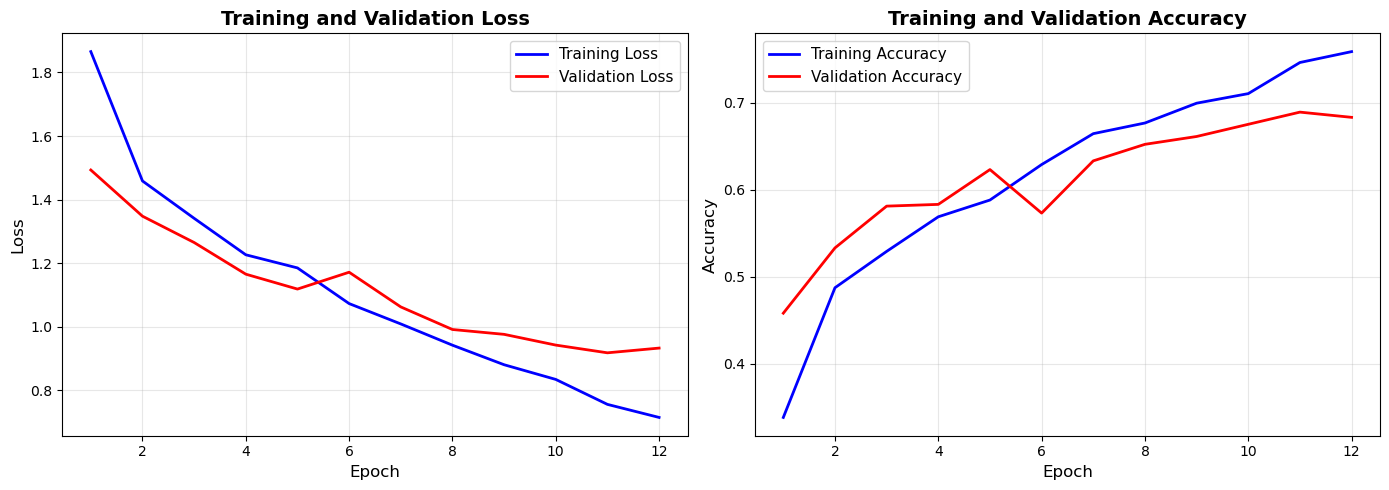


Training Summary:
  Final Train Loss: 0.7138
  Final Train Accuracy: 75.85%
  Final Val Loss: 0.9322
  Final Val Accuracy: 68.30%
  Best Val Accuracy: 68.90% (Epoch 11)


In [78]:
# Plot and print the loss and accuracy
training_report_plot(history_df)

### Display Misclassified Test Samples

This section identifies and displays misclassified samples from the test set, showing the predicted label vs the true label for each misclassified image.


In [79]:
def plot_misclass_samples(misclassified_images, misclassified_preds, misclassified_labels, 
                          selected_subset, num_samples, rows, cols):
    fig, axes = plt.subplots(rows, cols, figsize=(12, 12))
    fig.suptitle('Misclassified Test Samples (Predicted vs True Label)', fontsize=16, fontweight='bold')
    
    for idx in range(num_samples):
        row = idx // rows
        col = idx % cols
        ax = axes[row, col]
        
        # Get the image and transpose from (C, H, W) to (H, W, C) for matplotlib
        img = misclassified_images[idx].numpy().transpose(1, 2, 0)
        
        # Get predicted and true labels
        pred_label = misclassified_preds[idx].item()
        true_label = misclassified_labels[idx].item()
        
        # Map remapped labels (0-9) back to original class IDs
        pred_class_id = selected_subset[pred_label]
        true_class_id = selected_subset[true_label]
        
        # Get class names
        pred_class_name = cifar100_full.classes[pred_class_id]
        true_class_name = cifar100_full.classes[true_class_id]
        
        # Display image
        ax.imshow(img)
        ax.set_title(f'Pred: {pred_class_name}\nTrue: {true_class_name}', 
                     fontsize=10, color='red' if pred_label != true_label else 'green')
        ax.axis('off')
    
    # Hide unused subplots
    for idx in range(num_samples, 16):
        row = idx // 4
        col = idx % 4
        axes[row, col].axis('off')
    
    plt.tight_layout()
    plt.show()

def test_loop_with_misclass(model, test_loader, cifar100_test):
    # Compute test accuracy and collect misclassified samples
    model.eval()
    misclassified_images = []
    misclassified_preds = []
    misclassified_labels = []
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            
            # Find misclassified samples
            misclassified_mask = (predicted != labels)
            misclassified_images.append(images[misclassified_mask].cpu())
            misclassified_preds.append(predicted[misclassified_mask].cpu())
            misclassified_labels.append(labels[misclassified_mask].cpu())

    # Concatenate all misclassified samples
    if misclassified_images:
        misclassified_images = torch.cat(misclassified_images, dim=0)
        misclassified_preds = torch.cat(misclassified_preds, dim=0)
        misclassified_labels = torch.cat(misclassified_labels, dim=0)

        print(f"===============================================")
        print(f"Total misclassified samples: {len(misclassified_images)}")
        print(f"Test set size: {len(cifar100_test)}")
        print(f"Test accuracy: {(len(cifar100_test) - len(misclassified_images)) / len(cifar100_test):.2%}")
        
        # Display up to 16 misclassified samples in a 4x4 grid
        num_samples = min(16, len(misclassified_images))
        plot_misclass_samples(misclassified_images, misclassified_preds, misclassified_labels, 
                              selected_subset, num_samples, 4, 4)
        
    else:
        print("No misclassified samples found!")

Total misclassified samples: 331
Test set size: 1000
Test accuracy: 66.90%


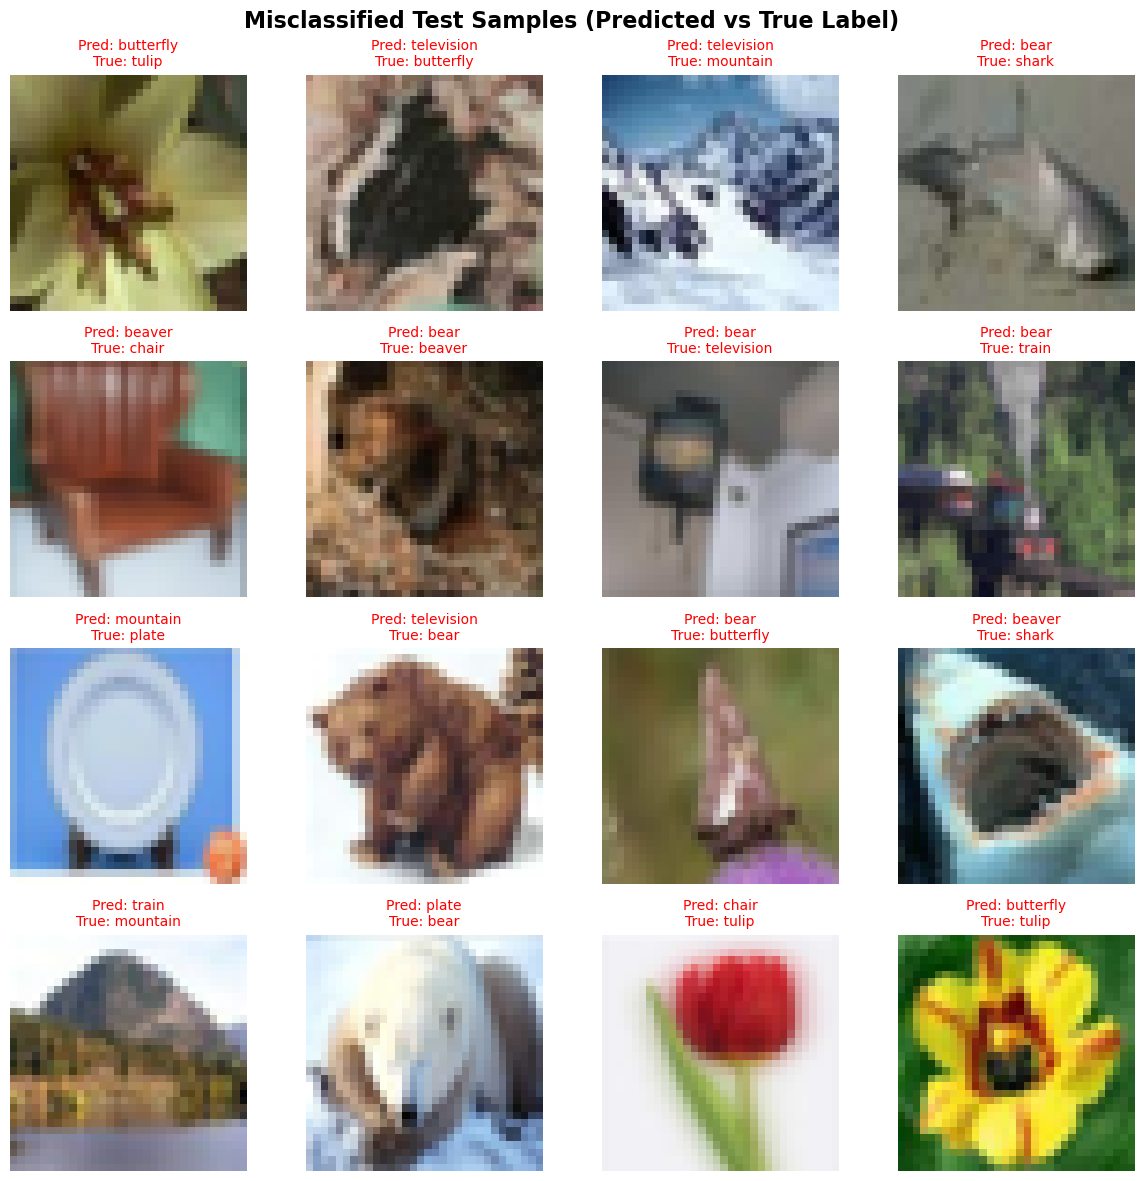

In [80]:
# Run the testing loop on the base model
test_loop_with_misclass(base_model, test_loader, cifar100_test)

Model Improvement

In [81]:
class ImprovedCnn(nn.Module):
    def __init__(self):
        super(ImprovedCnn, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),  # Conv1
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            
            nn.Conv2d(64, 64, kernel_size=3, padding=1), # depth [32,64] (base)→[64,64]
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 8 * 8, 256),  # assuming input is 32x32 (CIFAR); hidden layer 128(base)→256
            nn.ReLU(),
            nn.Linear(256, config['num_classes'])  # 10 classes for subset
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

Found model with specified name: models/baseline/cnn_balanced_20251105_102247.pt
Force training enabled. Training new model despite existing model(s).
Starting training for 12 epochs...
------------------------------------------------------------
Epoch 1/12: Train Loss = 1.8052, Train Acc = 35.25%, Val Loss = 1.3928, Val Acc = 49.60%
Epoch 2/12: Train Loss = 1.3933, Train Acc = 50.62%, Val Loss = 1.2631, Val Acc = 54.60%
Epoch 3/12: Train Loss = 1.2554, Train Acc = 55.62%, Val Loss = 1.1626, Val Acc = 60.00%
Epoch 4/12: Train Loss = 1.1230, Train Acc = 60.90%, Val Loss = 1.1401, Val Acc = 59.60%
Epoch 5/12: Train Loss = 1.0237, Train Acc = 64.60%, Val Loss = 1.0618, Val Acc = 63.90%
Epoch 6/12: Train Loss = 0.9357, Train Acc = 68.40%, Val Loss = 1.0651, Val Acc = 62.60%
Epoch 7/12: Train Loss = 0.8897, Train Acc = 69.27%, Val Loss = 0.9855, Val Acc = 66.90%
Epoch 8/12: Train Loss = 0.7622, Train Acc = 73.85%, Val Loss = 0.9680, Val Acc = 67.50%
Epoch 9/12: Train Loss = 0.7214, Train Ac

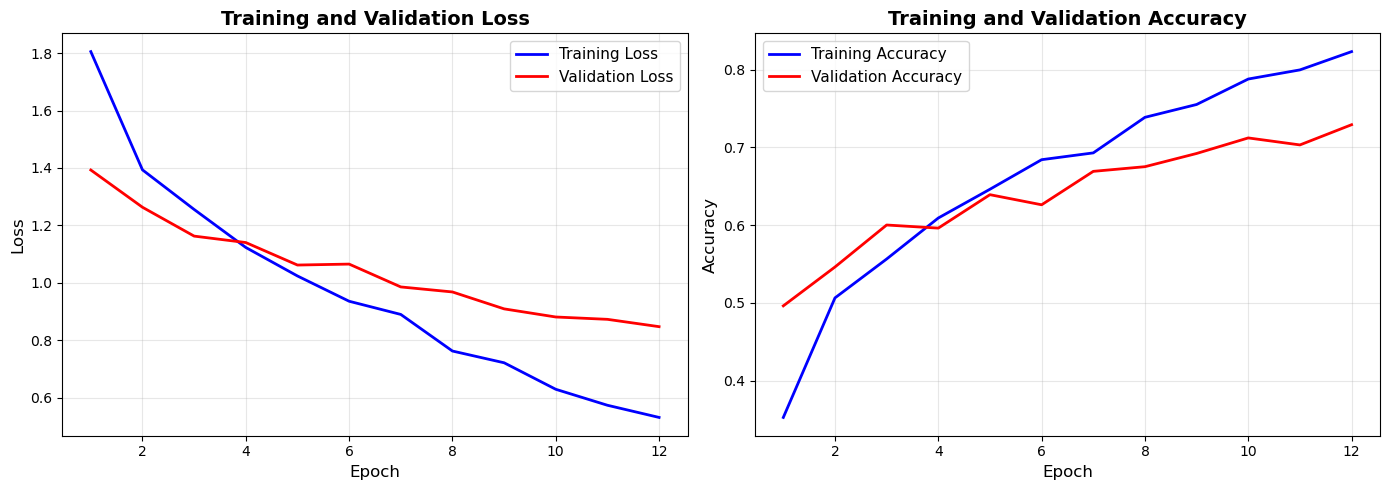


Training Summary:
  Final Train Loss: 0.5310
  Final Train Accuracy: 82.30%
  Final Val Loss: 0.8471
  Final Val Accuracy: 72.90%
  Best Val Accuracy: 72.90% (Epoch 12)
Total misclassified samples: 293
Test set size: 1000
Test accuracy: 70.70%


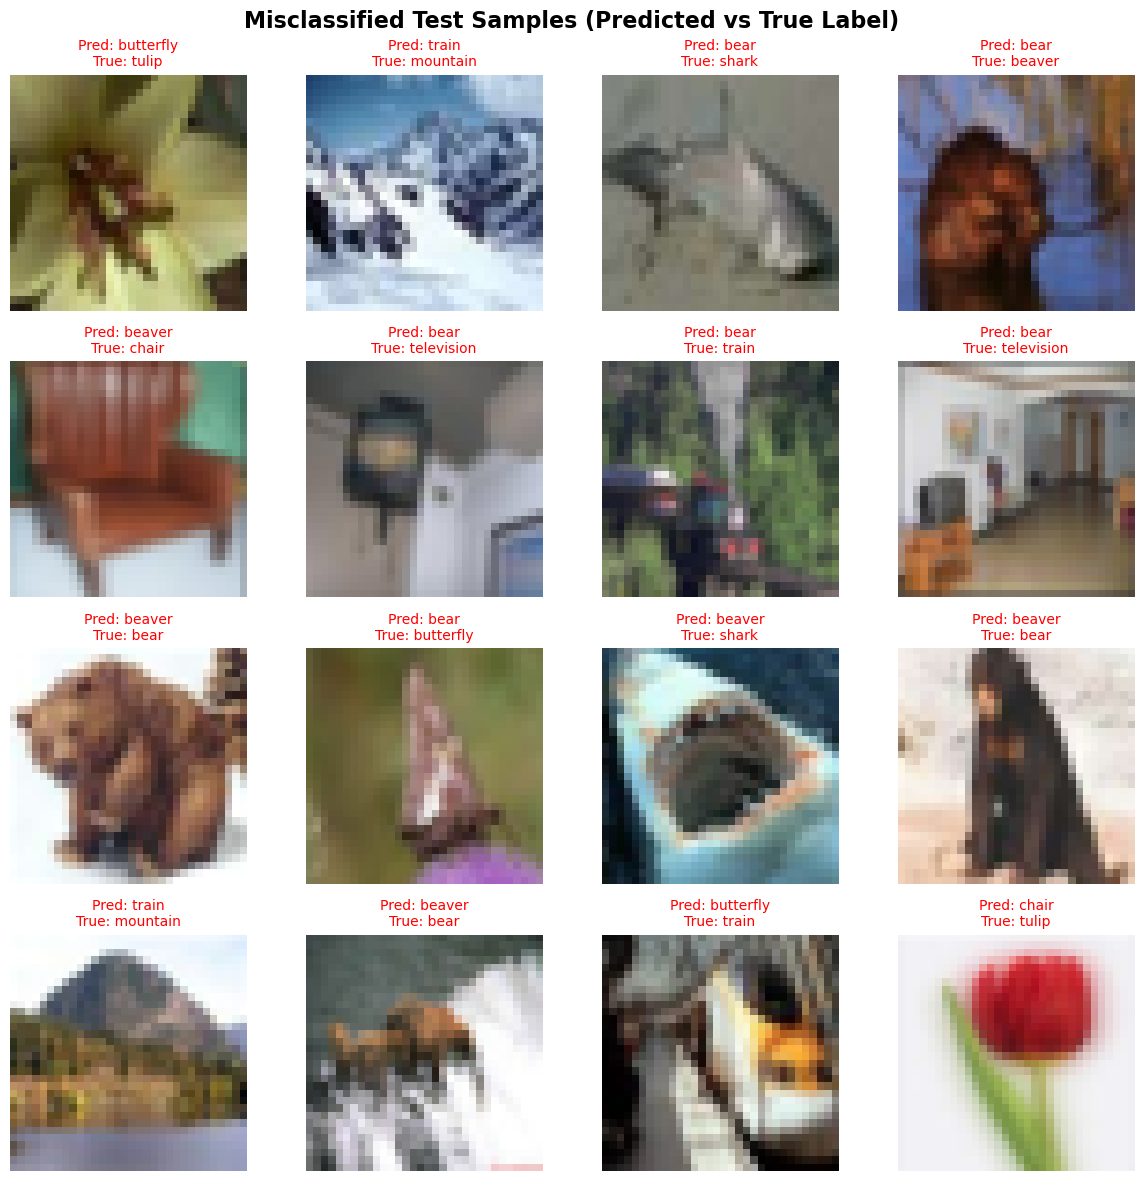

In [82]:
#-----------CHANGE THIS PATH LATER. TOO LAZY ZZZ--------------------#
# Set the baseline model and report paths
baseline_model_dir = Path(config['model_dir']['baseline'])
baseline_reports_dir = Path(config['reports_dir']['baseline'])

# Initialize the directory (path) to save the model and reports
model_dir = baseline_model_dir
reports_dir = baseline_reports_dir
#-----------CHANGE THIS PATH LATER. TOO LAZY ZZZ--------------------#


# Initialized the improved cnn model, and ensure the the model is moved to the device
improved_model = ImprovedCnn().to(device)

# Improved model - Train or load
history_df = load_or_train(config, model_dir, improved_model, device, reports_dir, train_loader, val_loader)

# Plot and print the loss and accuracy
training_report_plot(history_df)

# Run the testing loop on the improved model
test_loop_with_misclass(improved_model, test_loader, cifar100_test)

Files already downloaded and verified
Using Subset balanced with classes: [4, 73, 92, 61, 87, 20, 14, 3, 49, 90]
Class names: ['beaver', 'shark', 'tulip', 'plate', 'television', 'chair', 'butterfly', 'bear', 'mountain', 'train']
Files already downloaded and verified

Dataset Statistics:
  Training set size: 4000
  Validation set size: 1000
  Test set size: 1000
  Number of classes: 10
  Selected classes: [4, 73, 92, 61, 87, 20, 14, 3, 49, 90]
Found model with specified name: models/baseline/cnn_balanced_20251105_102247.pt
Force training enabled. Training new model despite existing model(s).
Starting training for 12 epochs...
------------------------------------------------------------
Epoch 1/12: Train Loss = 1.5944, Train Acc = 43.70%, Val Loss = 1.2238, Val Acc = 56.50%
Epoch 2/12: Train Loss = 1.2282, Train Acc = 56.65%, Val Loss = 1.0430, Val Acc = 64.00%
Epoch 3/12: Train Loss = 1.0376, Train Acc = 63.20%, Val Loss = 0.9714, Val Acc = 66.60%
Epoch 4/12: Train Loss = 0.9306, Train 

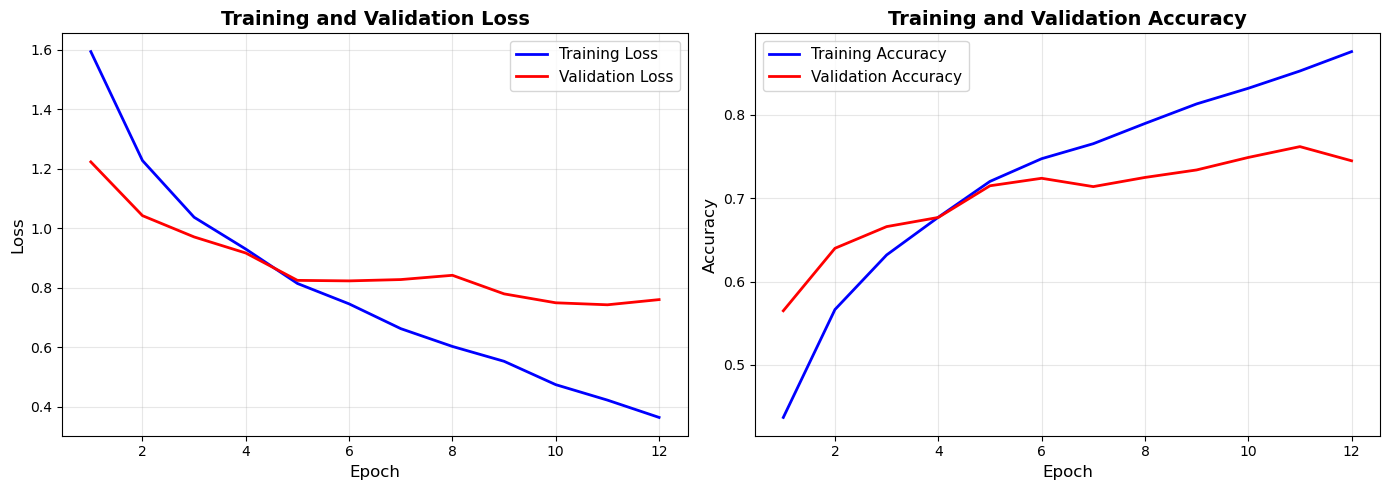


Training Summary:
  Final Train Loss: 0.3648
  Final Train Accuracy: 87.60%
  Final Val Loss: 0.7608
  Final Val Accuracy: 74.50%
  Best Val Accuracy: 76.20% (Epoch 11)
Total misclassified samples: 248
Test set size: 1000
Test accuracy: 75.20%


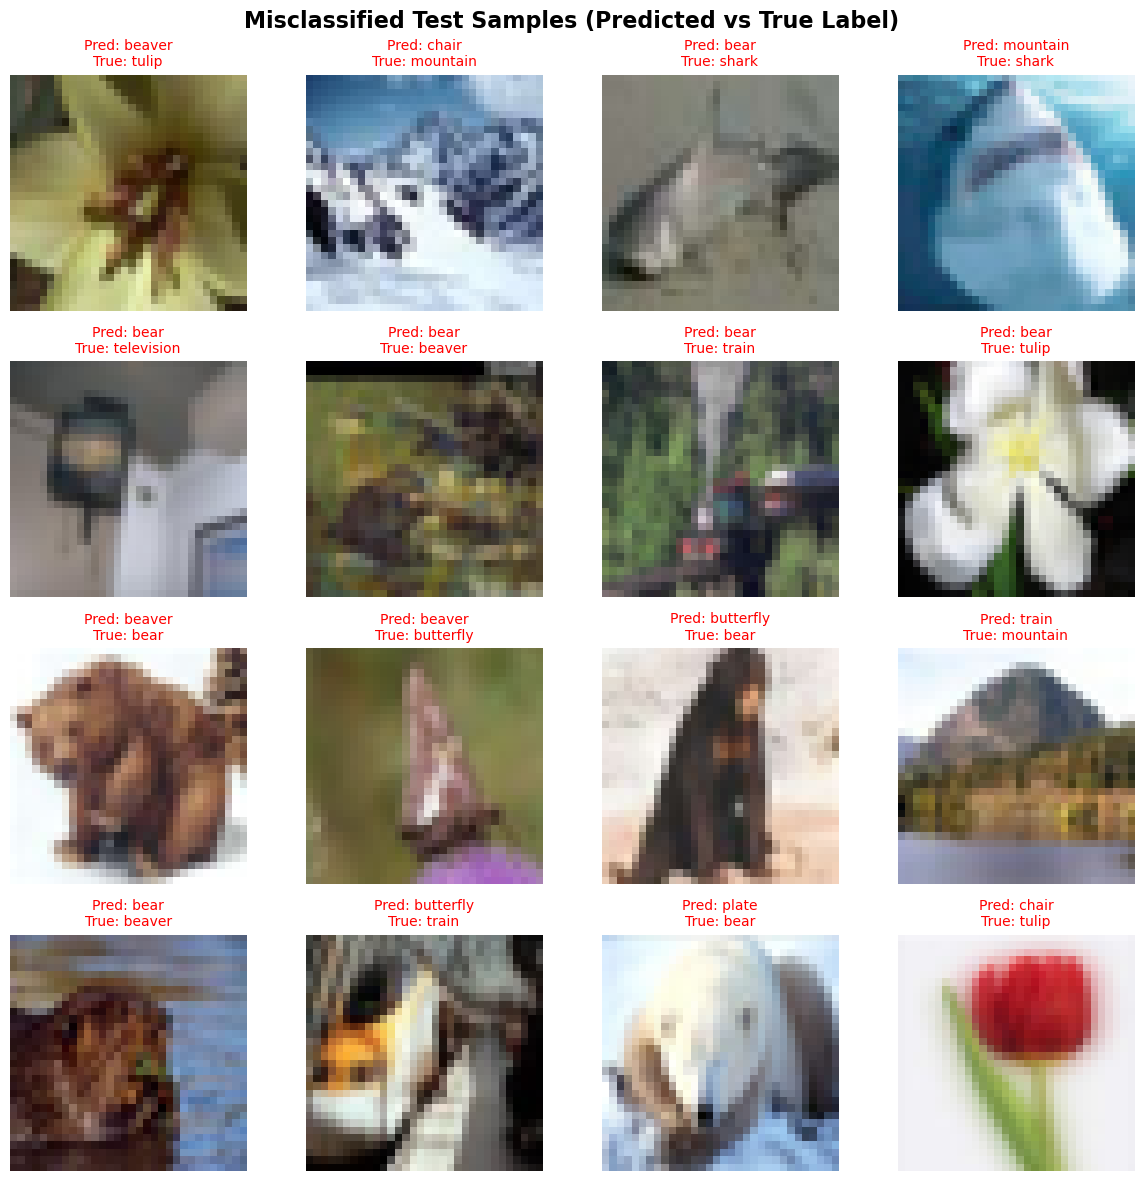

In [88]:
class ImprovedCnn_w_dropout(nn.Module):
    def __init__(self):
        super(ImprovedCnn_w_dropout, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),  # Conv1
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            
            nn.Conv2d(64, 64, kernel_size=3, padding=1), # depth [32,64] (base)→[64,64]
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            # Add a dropout=0.2
            nn.Dropout(0.2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 8 * 8, 256),  # assuming input is 32x32 (CIFAR); hidden layer 128(base)→256
            nn.ReLU(),
            nn.Linear(256, config['num_classes'])  # 10 classes for subset
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

# Add RandomHorizontalFlip=0.5
improved_transform_rand_flip = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(p=0.5)
])

improved_batch_size = 32  # Change the batch size from 128 -> 32

# Get the updated loaders
cifar100_full, cifar100_test, train_loader, val_loader, test_loader = get_train_val_test_loaders(improved_transform_rand_flip, improved_batch_size)

# Initialized the improved cnn model, and ensure the the model is moved to the device
improved_model_w_dropout = ImprovedCnn_w_dropout().to(device)

# Improved model + Resize + Normalized - Train or load
history_df = load_or_train(config, model_dir, improved_model_w_dropout, device, reports_dir, train_loader, val_loader)

# Plot and print the loss and accuracy
training_report_plot(history_df)

# Run the testing loop on the improved model
test_loop_with_misclass(improved_model_w_dropout, test_loader, cifar100_test)

Files already downloaded and verified
Using Subset balanced with classes: [4, 73, 92, 61, 87, 20, 14, 3, 49, 90]
Class names: ['beaver', 'shark', 'tulip', 'plate', 'television', 'chair', 'butterfly', 'bear', 'mountain', 'train']
Files already downloaded and verified

Dataset Statistics:
  Training set size: 4000
  Validation set size: 1000
  Test set size: 1000
  Number of classes: 10
  Selected classes: [4, 73, 92, 61, 87, 20, 14, 3, 49, 90]
Found model with specified name: models/baseline/cnn_balanced_20251105_102247.pt
Force training enabled. Training new model despite existing model(s).
Starting training for 12 epochs...
------------------------------------------------------------
Epoch 1/12: Train Loss = 2.1988, Train Acc = 33.15%, Val Loss = 1.4573, Val Acc = 48.20%
Epoch 2/12: Train Loss = 1.4063, Train Acc = 50.32%, Val Loss = 1.2508, Val Acc = 56.20%
Epoch 3/12: Train Loss = 1.2002, Train Acc = 58.43%, Val Loss = 1.2013, Val Acc = 58.70%
Epoch 4/12: Train Loss = 1.0506, Train 

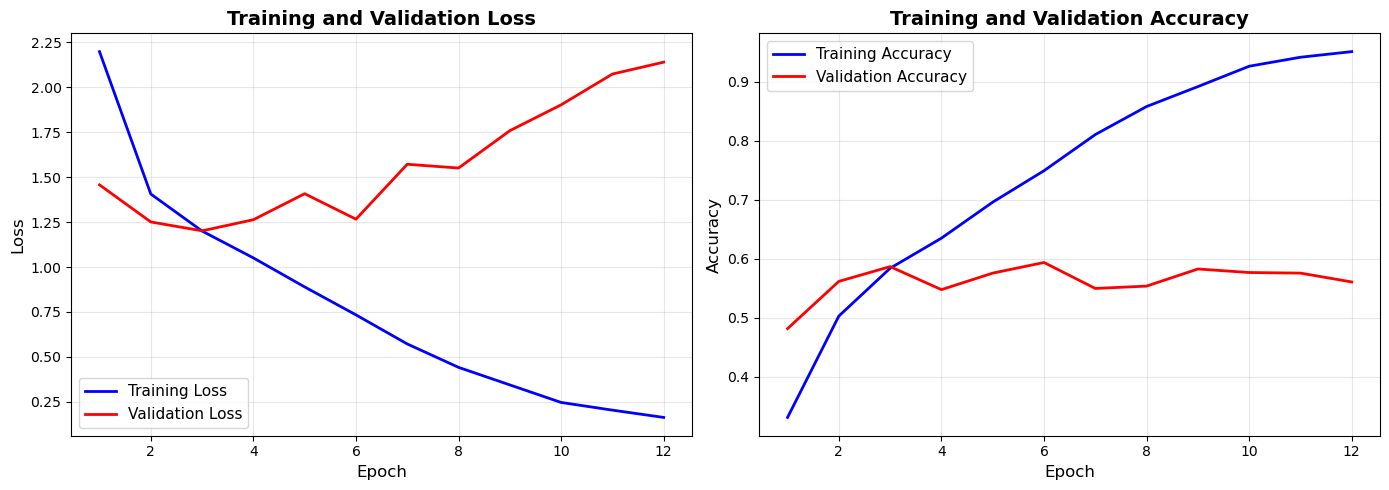


Training Summary:
  Final Train Loss: 0.1627
  Final Train Accuracy: 95.12%
  Final Val Loss: 2.1402
  Final Val Accuracy: 56.10%
  Best Val Accuracy: 59.40% (Epoch 6)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.6681343..1.8024156].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.5458243..1.3295144].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.759867..1.1589435].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.26140004..2.025353].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.4265786..1.7838947].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.55205435..2.025353].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.6528456

Total misclassified samples: 469
Test set size: 1000
Test accuracy: 53.10%


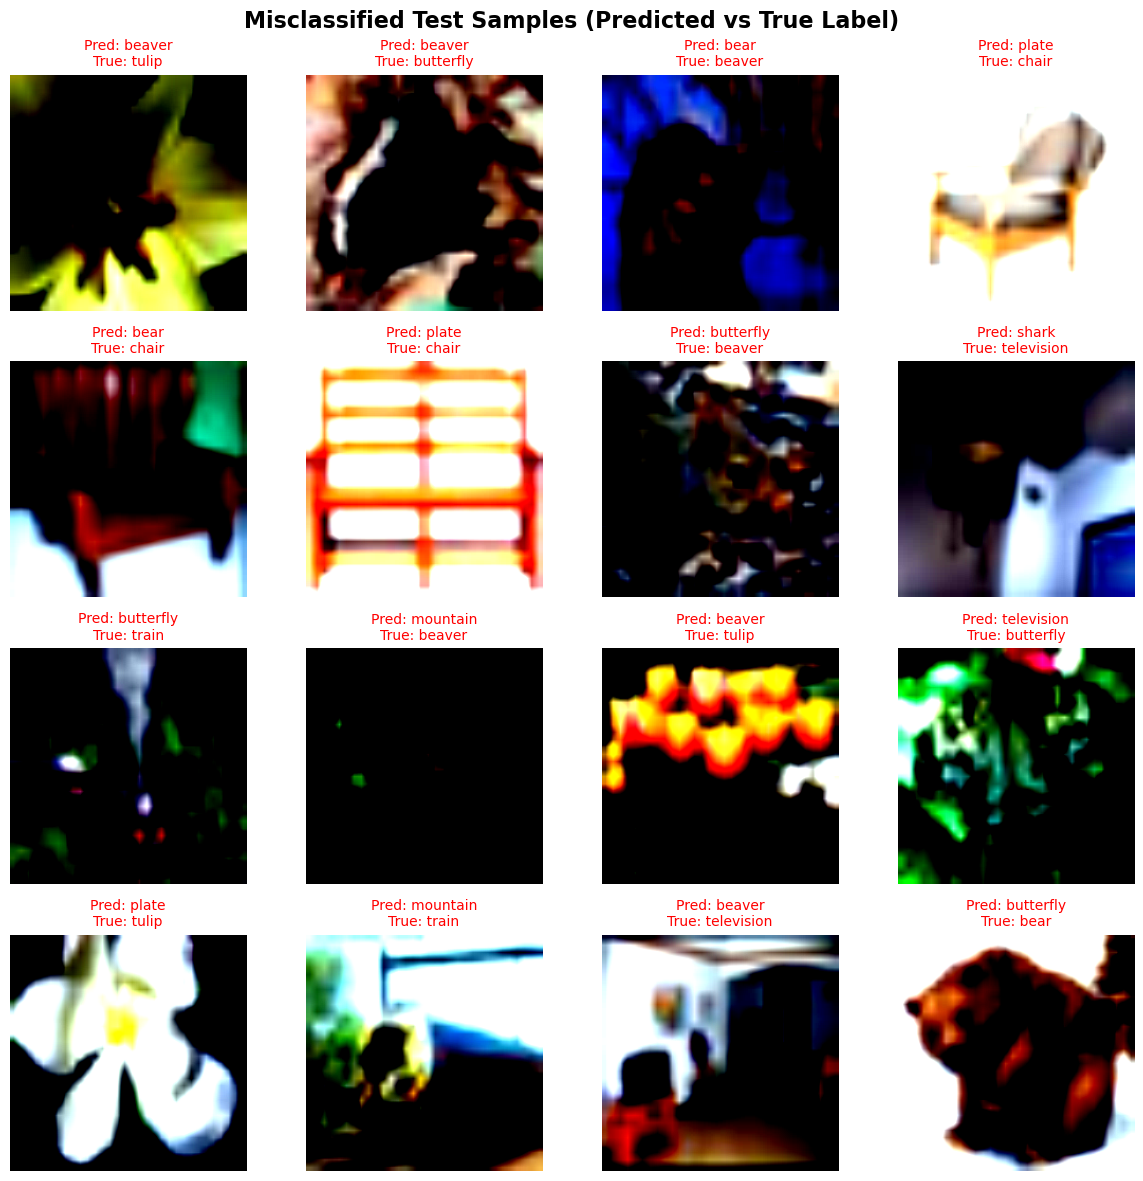

In [87]:
class ImprovedCnn_for_resize(nn.Module):
    def __init__(self):
        super(ImprovedCnn_for_resize, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),  # Conv1
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 224 -> 112
            
            nn.Conv2d(64, 64, kernel_size=3, padding=1), # depth [32,64] (base)→[64,64]
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 112 -> 56

            # Add a dropout=0.2
            nn.Dropout(0.2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.LazyLinear(256),  # I am too lazy to compute the linear - Wing
            nn.ReLU(),
            nn.Linear(256, config['num_classes'])  # 10 classes for subset
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

# Resize to 224, and normalize the dataset
improved_transform_224 = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5071, 0.4867, 0.4408], std=[0.2675, 0.2565, 0.2761])
])

improved_batch_size = 32  # Change the batch size from 128 -> 32

# Get the updated loaders
cifar100_full, cifar100_test, train_loader, val_loader, test_loader = get_train_val_test_loaders(improved_transform_224, improved_batch_size)

# Initialized the improved cnn model
improved_model_for_size = ImprovedCnn_for_resize()

# Ensure the the model is moved to the device
improved_model_for_size = improved_model_for_size.to(device)

# Improved model + Resize + Normalized - Train or load
history_df = load_or_train(config, model_dir, improved_model_for_size, device, reports_dir, train_loader, val_loader)

# Plot and print the loss and accuracy
training_report_plot(history_df)

# Run the testing loop on the improved model
test_loop_with_misclass(improved_model_for_size, test_loader, cifar100_test)